In [138]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline


In [139]:
words = open("names.txt" , 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [140]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i , s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s , i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [141]:
import random

block_size = 8
def build_dataset(words):
    X , Y = [] , []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context) , '--->' , itos[ix])
            context = context[1 :] + [ix]
 
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape , Y.shape) 
    return X , Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr , Ytr = build_dataset(words[:n1])     #train data
Xdev , Ydev = build_dataset(words[n1:n2]) #dev data
Xte , Yte = build_dataset(words[n2:])     #test data

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [142]:
for x,y in zip(Xtr[:20] , Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x) , '--->' , itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [143]:
class Linear:
    def __init__(self , fan_in , fan_out , bias=True):
        self.weight = torch.randn((fan_in , fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

#不同于pytorch的BatchNorm 
class BatchNorm1d:
    def __init__(self , dim , eps=1e-5 , momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self , x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0 , 1)
            xmean = x.mean(dim , keepdim = True)
            xvar = x.var(dim , keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out 

    def parameters(self):
        return [self.gamma , self.beta]
    
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
    
class Embedding:
    def __init__(self , num_embeddings , embedding_dim):
        self.weight = torch.randn((num_embeddings , embedding_dim))

    def __call__(self , x):
        self.out = self.weight[x]
        return self.out
    
    def parameters(self):
        return [self.weight]


class FlattenConsecutive:
    def __init__(self , n):
        self.n = n

    def __call__(self , x):
        B ,T , C = x.shape
        x = x.view(B , T // self.n , self.n * C)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    

class Sequential:
    def __init__(self , layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [144]:
torch.manual_seed(42)

In [149]:
n_embd = 10
n_hidden = 68


# C = torch.randn((vocab_size , n_embd))

model = Sequential([
    Embedding(vocab_size , n_embd),            #(batch_size * block_size * n_embd)
    FlattenConsecutive(2),Linear(n_embd * 2 , n_hidden , bias=False),
    BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2 , n_hidden , bias=False),
    BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2 , n_hidden , bias=False),
    BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden , vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

# parameters = [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()

print(sum(p.nelement() for p in parameters))
# print(type(model.parameters()))

for p in parameters:
    p.requires_grad = True

22397


In [150]:
ix = torch.randint(0 , Xtr.shape[0] , (4 , ))
Xb , Yb = Xtr[ix] , Ytr[ix] 
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  6],
        [ 0,  0,  0, 11,  1, 25, 12,  5],
        [ 0, 11,  5,  9, 13,  1, 18,  9],
        [ 0,  0,  0,  0,  0,  1, 14, 10]])

In [151]:
for layer in model.layers:
    print(layer.__class__.__name__ , ": " , tuple(layer.out.shape))

Embedding :  (4, 8, 10)
FlattenConsecutive :  (4, 4, 20)
Linear :  (4, 4, 68)
BatchNorm1d :  (4, 4, 68)
Tanh :  (4, 4, 68)
FlattenConsecutive :  (4, 2, 136)
Linear :  (4, 2, 68)
BatchNorm1d :  (4, 2, 68)
Tanh :  (4, 2, 68)
FlattenConsecutive :  (4, 136)
Linear :  (4, 68)
BatchNorm1d :  (4, 68)
Tanh :  (4, 68)
Linear :  (4, 27)


In [118]:
e = torch.randn((4 , 8 , 10))      #变为4 * 4 * 20
print(e.shape) 
print(len([e[: , ::2 , :] , e[: , 1::2 , :]]))  
#分别取奇数部分和偶数部分进行拼接
explicit = torch.cat([e[: , ::2 , :] , e[: , 1::2 , :]] , dim=2)
print(explicit.shape)
print(e.view(4 , 4 , 20).shape)
print((e.view(4 , 4 , 20) == explicit).all())

torch.Size([4, 8, 10])
2
torch.Size([4, 4, 20])
torch.Size([4, 4, 20])
tensor(True)


In [101]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0 , Xtr.shape[0] , (batch_size , ))
    Xb , Yb = Xtr[ix] , Ytr[ix]

    # emb = C[Xb]
    # x = emb.view(emb.shape[0] , -1)
    
    # x = Xb
    #forward
    # for layer in layers:
    #     x = layer(x)
    logits = model(Xb)
    loss = F.cross_entropy(logits , Yb)

    #backward
    # for layer in layers:
    #     layer.out.retain_grad()
    
    for p in parameters:
        p.grad = None

    loss.backward()

    #update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if (i + 1) % 10000 == 0:
        print(f'{i + 1:7d}/{max_steps:7d}: {loss.item():.4f}')
    elif i == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.2847


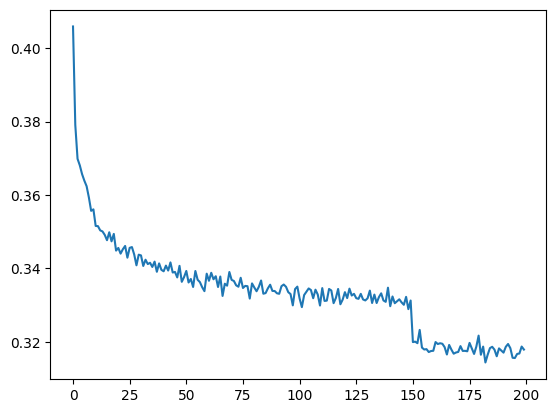

In [74]:
plt.plot(torch.tensor(lossi).view(-1 , 1000).mean(1))
# plt.plot(lossi)

In [75]:
for layer in model.layers:
    layer.training = False

@torch.no_grad()
def split_loss(split):
    x , y = {
        'train' : (Xtr , Ytr) , 
        'val' : (Xdev , Ydev) ,
        'test' : (Xte , Yte),
    }[split]
    # emb = C[x]        #(N , block_size , n_embd)
    # x = emb.view(emb.shape[0] , -1)
    # for layer in layers:
    #     x = layer(x)
    logits = model(x)
    loss = F.cross_entropy(logits , y)
    print(split , loss.item())

split_loss('train')
split_loss('val')

train 2.0583252906799316
val 2.1065292358398438


In [86]:
#sample from model

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # emb = C[torch.tensor([context])]      #(1 , block_size , n_embd)
        # # print(emb.shape)
        # x = emb.view(emb.shape[0] , -1)
        # for layer in layers:
        #     x = layer(x)
        # logits = x
        '''
        torch.tensor(context) 和 torch.tensor([context])的结果不同
        前者直接根据context的维度生成张量，后者在原有维度前增加一个大小为1的维度(n+1维张量)
        '''
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits , dim=1)
        ix = torch.multinomial(probs , num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

brece.
delikajabrir.
nafinley.
mahyanison.
montiarah.
janusomilli.
aveena.
savah.
julo.
lalita.
alaodalya.
jhavareen.
kavri.
ros.
anyah.
jullion.
jakyas.
matalindrayna.
royah.
brieller.
